In [1304]:
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [1305]:
#### Preprocecing ###

In [1306]:
Confirmed = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

In [1307]:
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
del df['Russia']
del df['Saudi Arabia']
confirmed = df

In [1361]:
contries = confirmed.max() >= 1000
confirmed = confirmed.loc[:, contries]
confirmed.columns.

Index(['Australia', 'Austria', 'Belgium', 'Brazil', 'Canada', 'Chile', 'China',
       'Czechia', 'Denmark', 'Ecuador', 'Finland', 'France', 'Germany',
       'Greece', 'Indonesia', 'Iran', 'Ireland', 'Israel', 'Italy', 'Japan',
       'Korea, South', 'Luxembourg', 'Malaysia', 'Netherlands', 'Norway',
       'Pakistan', 'Philippines', 'Poland', 'Portugal', 'Romania',
       'South Africa', 'Spain', 'Sweden', 'Switzerland', 'Thailand', 'Turkey',
       'US', 'United Kingdom'],
      dtype='object', name='Country/Region')

In [1309]:
df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
del df['Russia']
del df['Saudi Arabia']
recovered = df.loc[:, contries]

In [1310]:
df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
del df['Russia']
del df['Saudi Arabia']
death = df.loc[:, contries]

In [1311]:
removed = recovered + death

In [1312]:
### Data Preparation ###

In [1313]:
S = confirmed.values
R = removed.values
L=5

In [1314]:
data = {'T': S.shape[0], 'N': S.shape[1], 'L': L, 'S': S, 'R': R}

In [1315]:
### Model ###

In [1316]:
sm = pystan.StanModel(file="covid19.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6697c03e940e8c41baf7bf7f8f621636 NOW.


In [1317]:
# Train the model and generate samples
fit = sm.sampling(data=data)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [1318]:
### Simulation and Visualization functions ###

In [1319]:
T = S.shape[0]
N = S.shape[1]
epoch = pd.to_datetime('2020-01-22')

In [1320]:
def simulate(a, p, c, sigma_S, sigma_R, start, horizen):
    cumulative = confirmed.loc[start].values
    recovered = removed.loc[start].values
    infected_list = [(confirmed - removed).loc[d].values for d in 
                        pd.date_range(start - pd.Timedelta(days=L), periods=L, freq='D')]
    cumulative_list = [confirmed.loc[d].values for d in 
                        pd.date_range(start - pd.Timedelta(days=L), periods=L, freq='D')]
    for d in range(horizen):
        I = infected_list[-L] @ c * (1 - cumulative_list[-L] / p) + np.sqrt(sigma_S) * np.random.randn(N)
        cumulative = cumulative + np.clip(I, 0, cumulative - recovered)
        recovered = recovered + a * (cumulative_list[-1] - recovered) + np.sqrt(sigma_R) * np.random.randn(N)
        recovered = np.clip(recovered, 0, cumulative)
        infected_list.append(cumulative - recovered)
        cumulative_list.append(cumulative)
        
    infected = pd.DataFrame(infected_list[L:], 
                            columns=confirmed.columns,
                            index=pd.date_range(start, periods=horizen, freq='D'))
    cumulative = pd.DataFrame(cumulative_list[L:], 
                            columns=confirmed.columns,
                            index=pd.date_range(start, periods=horizen, freq='D'))
    return infected, cumulative

In [1321]:
def draw_infected(fit, start, horizen, country):
    a_s = fit['a']
    p_s = fit['p']
    c_s = fit['c']
    sigma_S_s = fit['sigma_S']
    sigma_R_s = fit['sigma_R']
    n = a_s.shape[0]
    data = pd.DataFrame()
    for i in range(5000):
        a = a_s[np.random.randint(n)]
        p = p_s[np.random.randint(n)]
        c = c_s[np.random.randint(n)]
        sigma_S = sigma_S_s[np.random.randint(n)]
        sigma_R = sigma_R_s[np.random.randint(n)]
        infected, cumulative = simulate(a, p, c, sigma_S, sigma_R, start, horizen)
        data = pd.concat([data, infected[country]], axis=1)
    graph = pd.DataFrame(index=pd.date_range(epoch - pd.Timedelta(days=L), 
                                             start + pd.Timedelta(days=horizen), freq='D'))
    real = (confirmed - removed)[country]
    median = data.median(axis=1)
    upper = data.quantile(q=0.75, axis=1)
    lower = data.quantile(q=0.25, axis=1)
    graph['Real'] = real
    graph['Median'] = median
    graph['Upper'] = upper
    graph['Lower'] = lower
    sns.relplot(kind="line", ci='sd', data=graph, aspect=2)

In [1322]:
### Validation ###

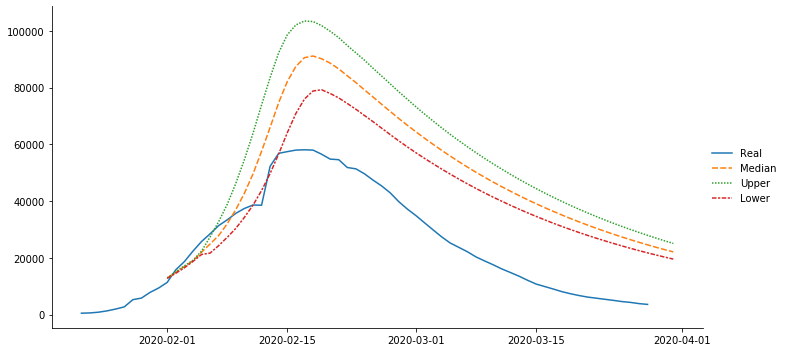

In [1323]:
draw_infected(fit, pd.to_datetime('2020-02-01'), 60, 'China')

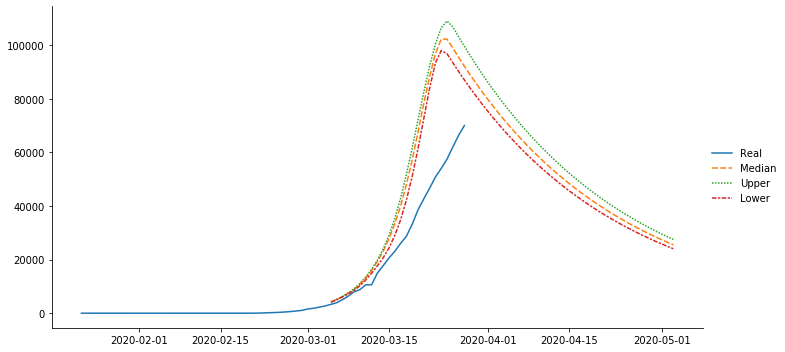

In [1324]:
draw_infected(fit, pd.to_datetime('2020-03-5'), 60, 'Italy')

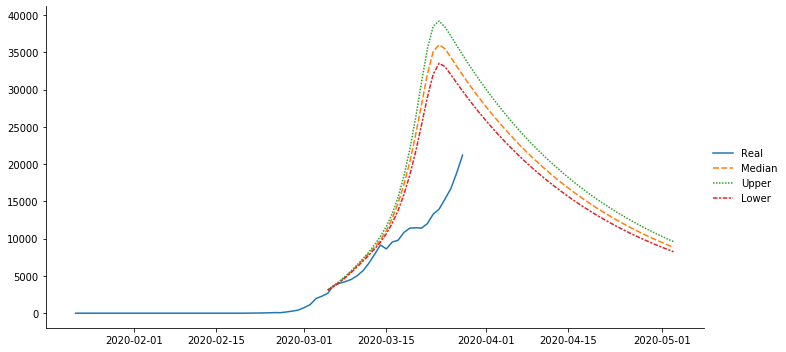

In [1325]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'Iran')

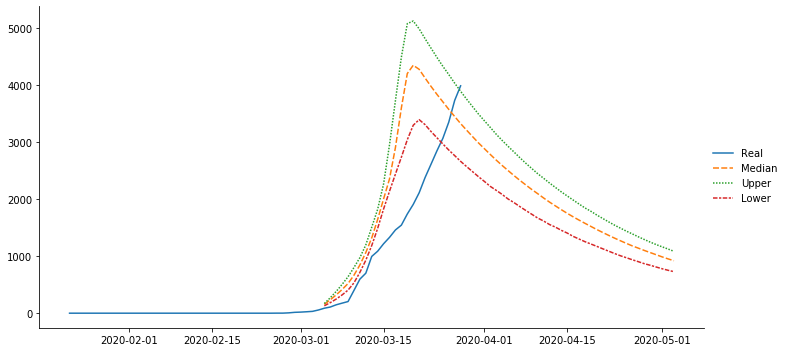

In [1326]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'Norway')

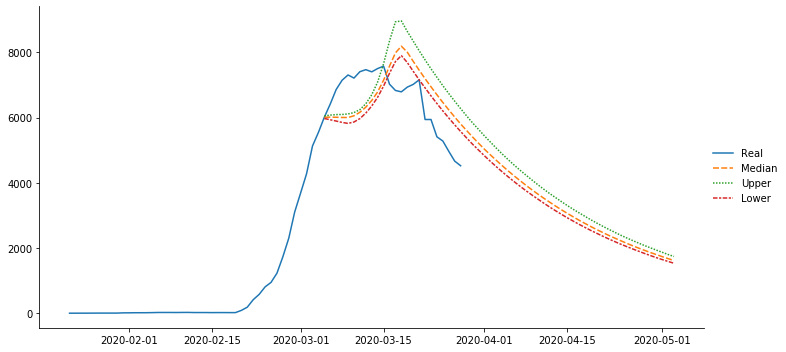

In [1327]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'Korea, South')

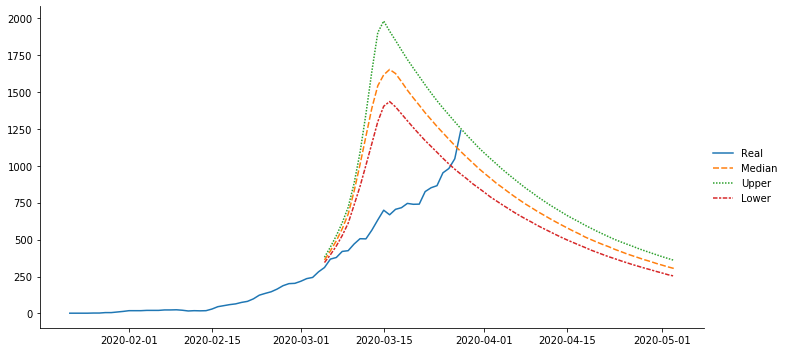

In [1328]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'Japan')

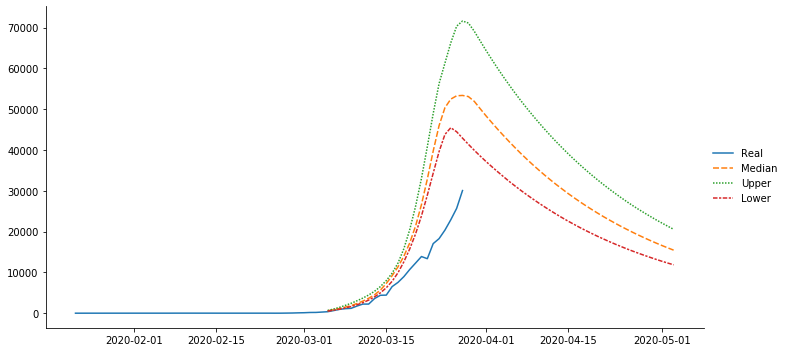

In [1329]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'France')

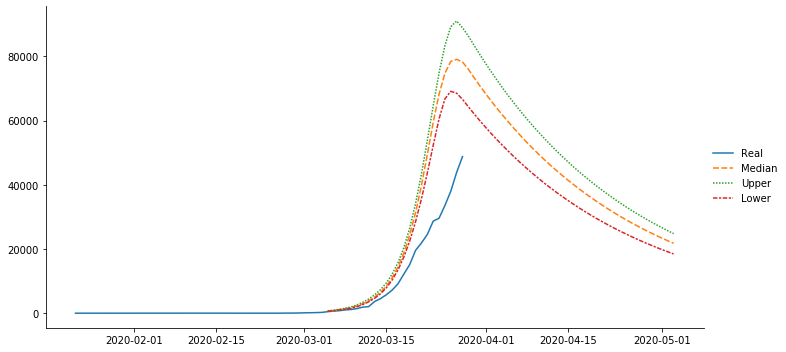

In [1330]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'Germany')

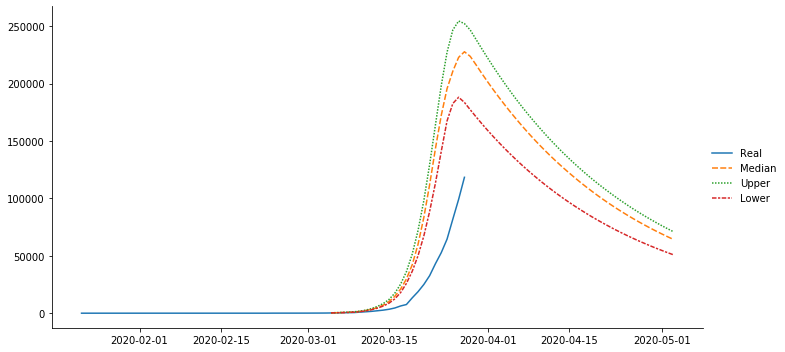

In [1331]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'US')

In [1332]:
### Prediction ###

In [1333]:
recent = confirmed.index[-1]


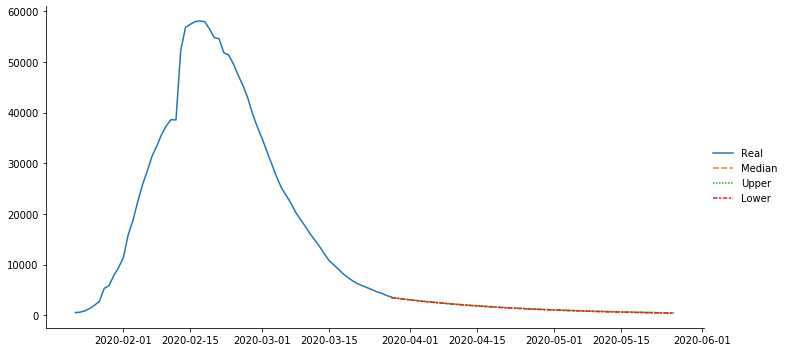

In [1334]:
draw_infected(fit, recent, 60, 'China')

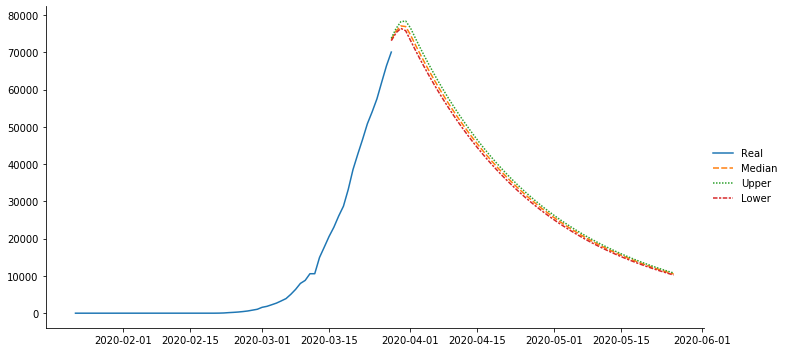

In [1335]:
draw_infected(fit, recent, 60, 'Italy')

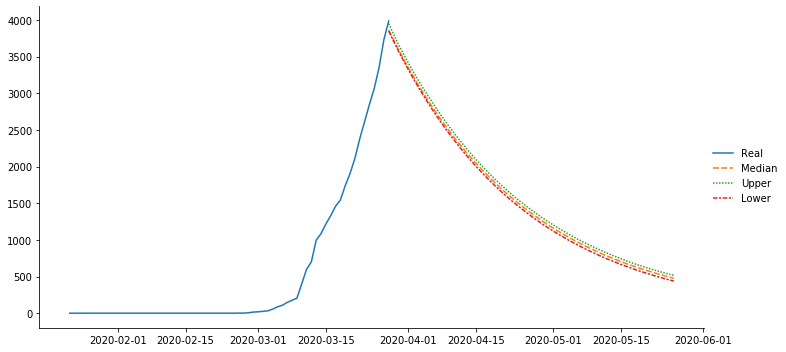

In [1336]:
draw_infected(fit, recent, 60, 'Norway')

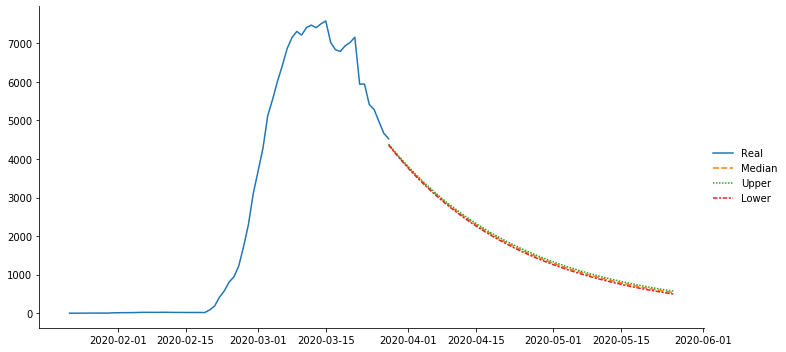

In [1337]:
draw_infected(fit, recent, 60, 'Korea, South')

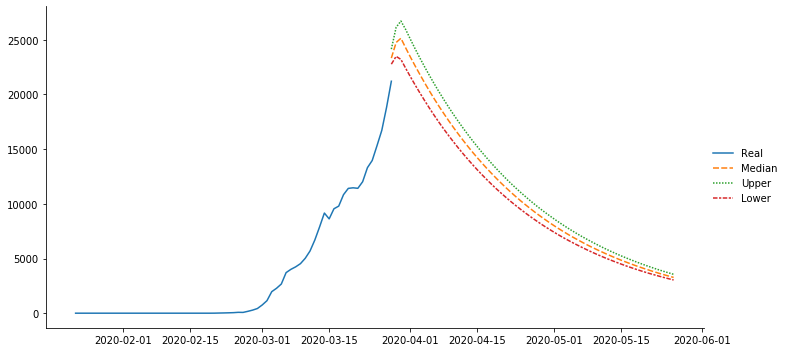

In [1338]:
draw_infected(fit, recent, 60, 'Iran')

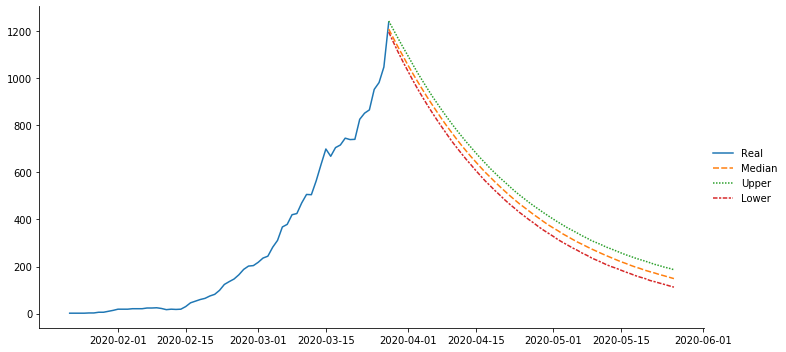

In [1339]:
draw_infected(fit, recent, 60, 'Japan')

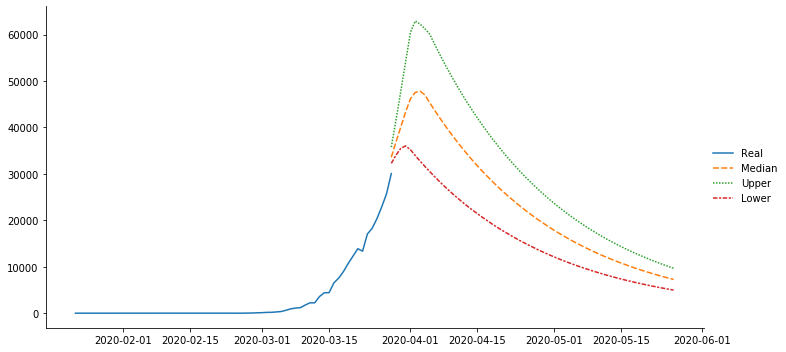

In [1340]:
draw_infected(fit, recent, 60, 'France')

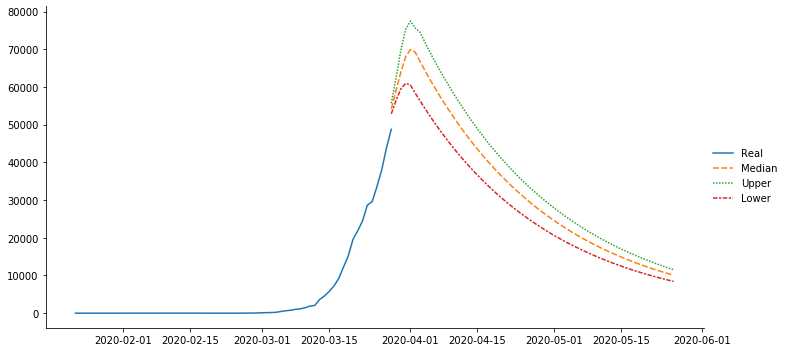

In [1341]:
draw_infected(fit, recent, 60, 'Germany')

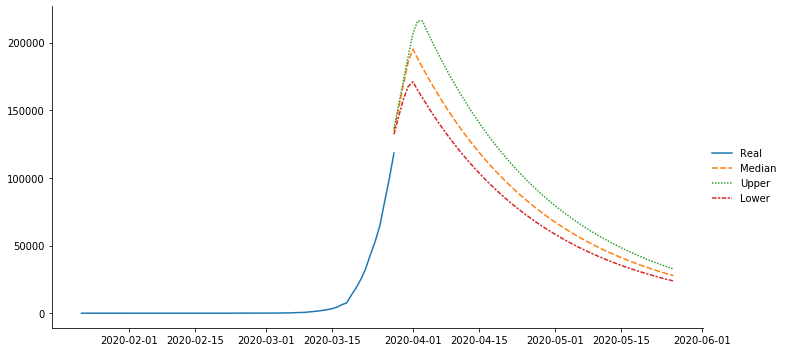

In [1342]:
draw_infected(fit, recent, 60, 'US')

In [1343]:
def draw_infected_world(fit, start, horizen):
    a_s = fit['a']
    p_s = fit['p']
    c_s = fit['c']
    sigma_S_s = fit['sigma_S']
    sigma_R_s = fit['sigma_R']
    n = a_s.shape[0]
    data = pd.DataFrame()
    cum = []
    for i in range(5000):
        a = a_s[np.random.randint(n)]
        p = p_s[np.random.randint(n)]
        c = c_s[np.random.randint(n)]
        sigma_S = sigma_S_s[np.random.randint(n)]
        sigma_R = sigma_R_s[np.random.randint(n)]
        infected, cumulative = simulate(a, p, c, sigma_S, sigma_R, start, horizen)
        data = pd.concat([data, infected.sum(axis=1)], axis=1)
        cum.append(cumulative.sum(axis=1).iloc[-1])
    cum = pd.Series(cum)
    graph = pd.DataFrame(index=pd.date_range('2020-01-22', start + pd.Timedelta(days=horizen)))
    real = (confirmed - removed).sum(axis=1)
    median = data.median(axis=1)
    upper = data.quantile(q=0.75, axis=1)
    lower = data.quantile(q=0.25, axis=1)
    graph['Real'] = real
    graph['Median'] = median
    graph['Upper'] = upper
    graph['Lower'] = lower
    sns.relplot(kind="line", ci='sd', data=graph, aspect=2);
    print("Upper:{}, Median:{}, Lower:{}".format(cum.quantile(q=0.75), cum.median(), cum.quantile(q=0.25)))

Upper:926048.9639415045, Median:873707.7067106849, Lower:853854.226596332


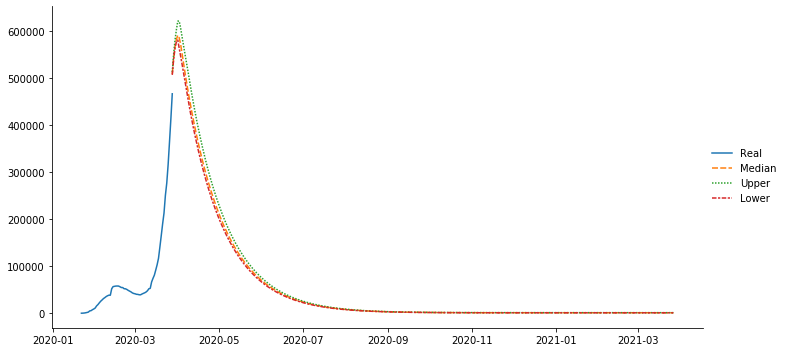

In [1344]:
draw_infected_world(fit, recent, 365)

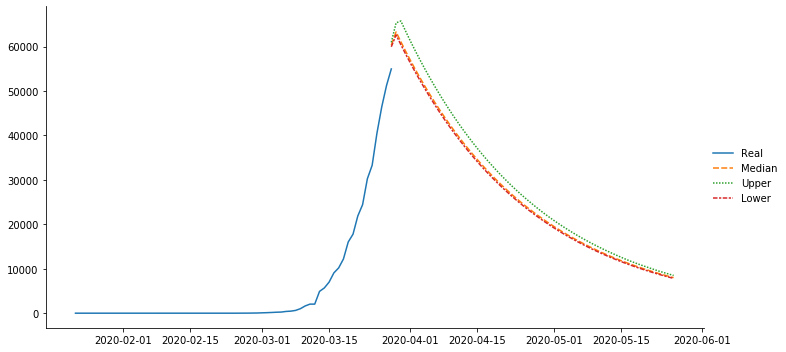

In [1345]:
draw_infected(fit, recent, 60, 'Spain')

In [1346]:
confirmed.columns

Index(['Australia', 'Austria', 'Belgium', 'Brazil', 'Canada', 'Chile', 'China',
       'Czechia', 'Denmark', 'Ecuador', 'Finland', 'France', 'Germany',
       'Greece', 'Indonesia', 'Iran', 'Ireland', 'Israel', 'Italy', 'Japan',
       'Korea, South', 'Luxembourg', 'Malaysia', 'Netherlands', 'Norway',
       'Pakistan', 'Philippines', 'Poland', 'Portugal', 'Romania',
       'South Africa', 'Spain', 'Sweden', 'Switzerland', 'Thailand', 'Turkey',
       'US', 'United Kingdom'],
      dtype='object', name='Country/Region')

In [1347]:
pystan.check_hmc_diagnostics(fit)

{'n_eff': False,
 'Rhat': False,
 'divergence': True,
 'treedepth': False,
 'energy': True}

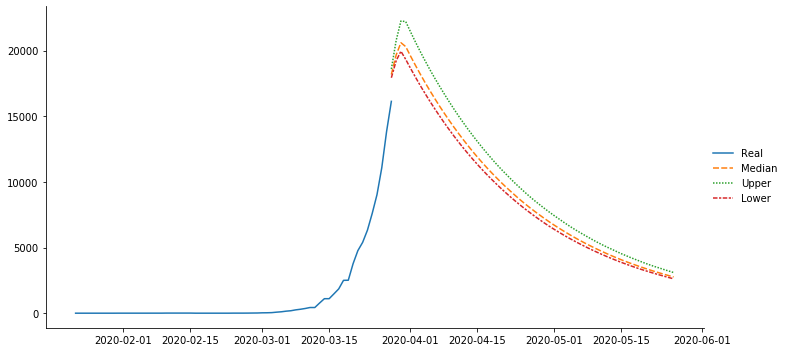

In [1348]:
draw_infected(fit, recent, 60, 'United Kingdom')

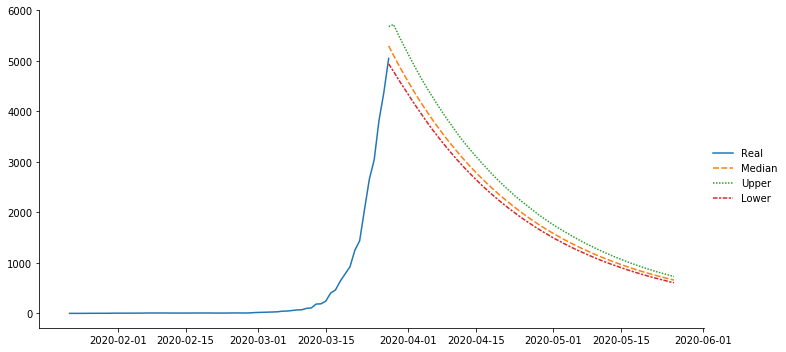

In [1349]:
draw_infected(fit, recent, 60, 'Canada')

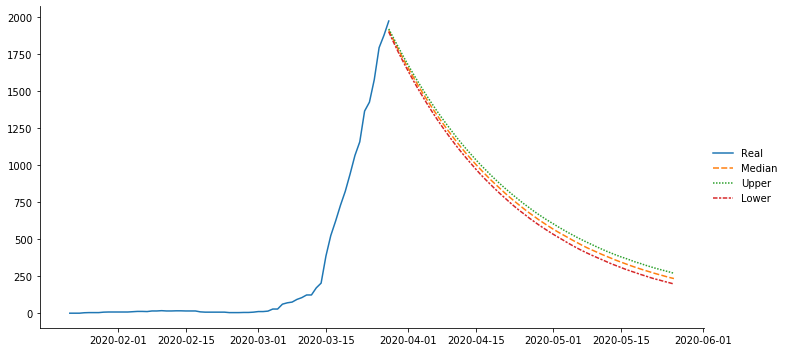

In [1350]:
draw_infected(fit, recent, 60, 'Malaysia')

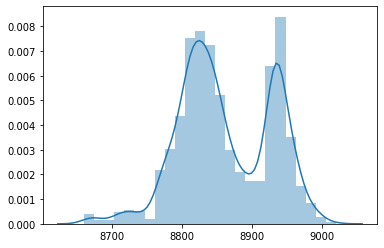

In [1388]:
sns.distplot(fit['p'][:,confirmed.columns.get_loc('Korea, South')])


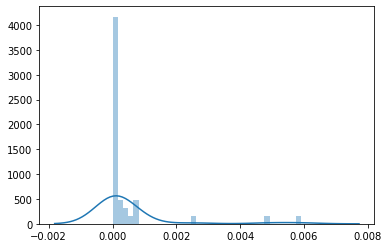

In [1394]:
n = confirmed.columns.get_loc('China')
sns.distplot(fit['c'][n,n])

In [1353]:
def draw_infected_sums(fit, start, horizen):
    a_s = fit['a']
    p_s = fit['p']
    c_s = fit['c']
    sigma_S_s = fit['sigma_S']
    sigma_R_s = fit['sigma_R']
    n = a_s.shape[0]
    data = pd.DataFrame()
    for i in range(10):
        a = a_s[np.random.randint(n)]
        p = p_s[np.random.randint(n)]
        c = c_s[np.random.randint(n)]
        sigma_S = sigma_S_s[np.random.randint(n)]
        sigma_R = sigma_R_s[np.random.randint(n)]
        _, cumulative = simulate(a, p, c, sigma_S, sigma_R, start, horizen)
        data = pd.concat([data, cumulative.iloc[-1]], axis=1)
    melted = pd.melt(data.T).rename(columns={'value':'Infected'})
    my_order = melted.groupby(by=['Country/Region'])['Infected'].median().sort_values(ascending=False).index
    plt.figure(figsize=(10,20))
    sns.boxplot(data=melted, y = 'Country/Region', x='Infected', showfliers=False, order=my_order)
    table = pd.DataFrame({'Lower':data.quantile(q=0.25, axis=1), 
                           'Median':data.median(axis=1), 
                           'Upper':data.quantile(0.75, axis=1)})
    return table

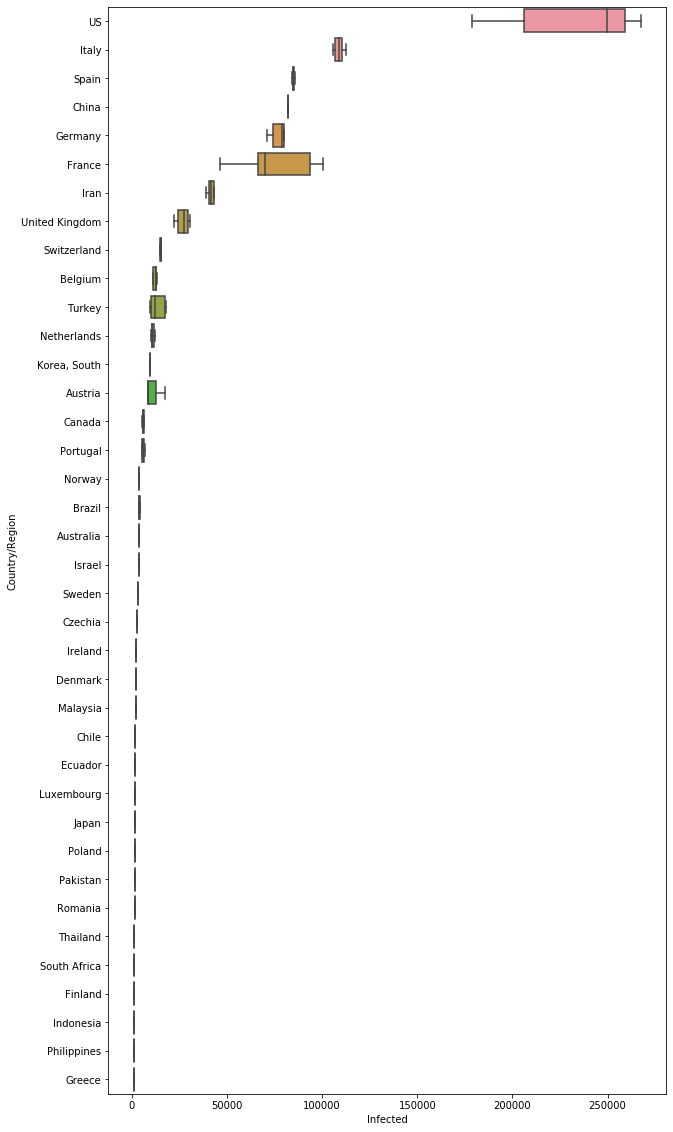

In [1354]:
data = draw_infected_sums(fit, recent, 365)

In [1355]:
data

,Lower,Median,Upper
Country/Region,,,
Australia,3640.000000,3682.204725,3852.674513
Austria,8396.399958,8463.290646,12581.770660
Belgium,11189.405717,12507.136460,12756.539914
Brazil,3917.039688,3928.212858,4113.021479
Canada,5855.720299,6063.878425,6198.236581
Chile,1909.000000,1909.000000,1909.000000
China,81999.000000,82005.582857,82025.760342
Czechia,2631.000000,2632.361478,2711.014486
Denmark,2366.000000,2366.000000,2394.694939


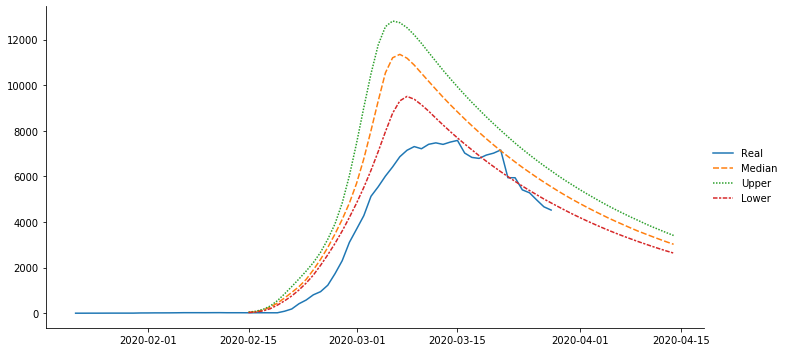

In [1356]:
draw_infected(fit, pd.to_datetime('2020-02-15'), 60, 'Korea, South')

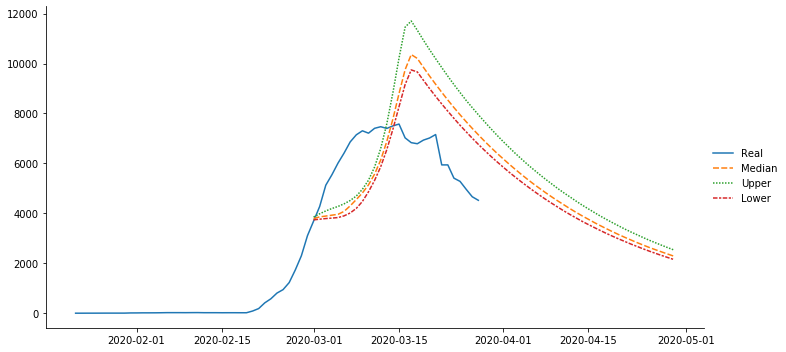

In [1357]:
draw_infected(fit, pd.to_datetime('2020-03-01'), 60, 'Korea, South')